# Question 1

### Q1.1 使用One-hot Encoding建構資料變數。所有資料變數都要是Numpy Array。

### Solve

1. Import data

2. Find x_train, which are fold <=6

3. Separate name in x_train, eg."承恩" -> “承”,“恩”,“承恩”, no change for 單名

4. Check whether each feature appear less than 1 time, if so delete the feature.

5. Now we get the feature list, which has size 1630 -> ['_Other_Feature_' '思' '安' ... '勒' '品嘉' '芷妘']

6. Process the data into feature matrix

    1. Check whether the name is in the feature list

    2. Check whether the name has two characters, if so check both of them, whether they are in feature matrix.

    3. If one condition didn't fulfill, set first column to 1, which is '_Other_Featuer_' = 1

7. Then check its fold, put it to the right subset.

In [1]:
# import data
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd

f = open('ds/namesex_data_v2.csv', 'r', encoding='utf8')
mydata = csv.DictReader(f)
sexlist = []
namelist = []
foldlist = []
for i, arow in enumerate(mydata):
    sexlist.append(int(arow['sex'].strip()))
    gname = arow['gname'].strip()
    namelist.append(gname)
    foldlist.append(int(arow['fold'].strip()))

sexlist = np.asarray(sexlist)
namelist = np.asarray(namelist)
foldlist = np.asarray(foldlist)
f.close()

In [2]:
raw_x_train = []

# get x_train
# separate name, aka "你好" -> "你","好","你好"
for sex,name,fold in zip(sexlist, namelist, foldlist):
    if fold <= 6:
        raw_x_train.append(name)
        if(len(name)!=1):
            raw_x_train.append(name[0])
            raw_x_train.append(name[1])


# Get feature list from training data (x_train), which are features that appear more than once
# If a feature appears only once, it will be replaced by '_Other_Feature_'
feature_list = pd.DataFrame(raw_x_train, columns=['name'])
name_counts = feature_list['name'].value_counts()
# Set feature that appears only once to '_Other_Feature_'
feature_list['name'] = feature_list['name'].apply(lambda raw_x: '_Other_Feature_' if name_counts[raw_x] < 2 else raw_x)
feature_list.drop_duplicates(subset=['name'], keep='first', inplace=True)
feature_list = np.array(feature_list.values.tolist()).reshape(-1)
feature_cnt = len(feature_list)

print(feature_cnt)
print(feature_list)

1630
['_Other_Feature_' '思' '安' ... '勒' '品嘉' '芷妘']


In [3]:
# Process the original rawdata, convert it into feature vectors
def to1hot(rawx, rawy):
    x = []
    y = []
    for i in range(len(rawx)):
        new_arr = np.zeros(feature_cnt)
        fullnamepos = np.where(feature_list == rawx[i])

        # if can't find the feature in feature_list, set '_Other_Feature_' feature to 1
        if fullnamepos[0].size == 0:
            new_arr[0] = 1
        else:
            new_arr[fullnamepos[0]] = 1

        if len(rawx[i]) == 2:
            separatenamepos1 = np.where(feature_list == rawx[i][0])
            separatenamepos2 = np.where(feature_list == rawx[i][1])

            # if can't find the feature in feature_list, set '_Other_Feature_' feature to 1
            if separatenamepos1[0].size == 0:
                new_arr[0] = 1
            else:
                new_arr[separatenamepos1[0]] = 1
                
            # if can't find the feature in feature_list, set '_Other_Feature_' feature to 1
            if separatenamepos2[0].size == 0:
                new_arr[0] = 1
            else:
                new_arr[separatenamepos2[0]] = 1
                
        x.append(new_arr)
        y.append(rawy[i])
    return np.asarray(x), np.asarray(y)

In [4]:
# empty the original rawdata, since we don't need separate name anymore, we only need to check the fold.
raw_x_train = []
raw_y_train = []
raw_x_valid = []
raw_y_valid = []
raw_x_stack = []
raw_y_stack = []
raw_x_test = []
raw_y_test = []

# Set the fold 0-6 as training data, 7 as validation data, 8 as stack data, 9 as test data
for sex,name,fold in zip(sexlist, namelist, foldlist):
    if fold <= 6:
        raw_x_train.append(name)
        raw_y_train.append(sex)
    if fold == 7:
        raw_x_valid.append(name)
        raw_y_valid.append(sex)
    if fold == 8:
        raw_x_stack.append(name)
        raw_y_stack.append(sex) 
    if fold == 9:
        raw_x_test.append(name)
        raw_y_test.append(sex)

# Convert the rawdata into feature vectors
x_train, y_train = to1hot(raw_x_train, raw_y_train)
x_test, y_test = to1hot(raw_x_test, raw_y_test)
x_valid, y_valid = to1hot(raw_x_valid, raw_y_valid)
x_stack, y_stack = to1hot(raw_x_stack, raw_y_stack)

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_valid.shape, y_valid.shape, x_stack.shape, y_stack.shape

((7483, 1630),
 (7483,),
 (1064, 1630),
 (1064,),
 (1110, 1630),
 (1110,),
 (1073, 1630),
 (1073,))

Then we can see: train has 7483 data, test has 1064, valid has 1110, stack has 1073

### Q1.2 使用`sklearn.linear_model.LogisticRegression()`建構Logistic Regression分類模型

### Solve 

Since Grid Search的小值為$10^{-4}$，最大值是$1,000$，總共取20個點，使用等比級數間隔。

First, get grid search list, which are the regulaization coeff we want to try.

Use `np.geomspace(1e-4, 1e3, num=20)` to get the list.

Then try every coeff in the list, find the best model which has best f1


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score

In [6]:
# 定義Grid Search範圍，取20個點，使用等比級數間隔
# 1m40s

# Grid Search
c_values = np.geomspace(1e-4, 1e3, num=20)
best_f1 = -1
best_c = -1
bestmodel = None

for c in c_values:
    model = LogisticRegression(C=c, max_iter=10000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid)
    f1 = f1_score(y_valid, y_pred)
    
    if f1 > best_f1:
        best_f1 = f1
        best_c = c
        bestmodel = model


print("Best Regularization Coefficient (bestc):", best_c)
print("Best F1 Score:", best_f1)
print("Best Model:", bestmodel)


Best Regularization Coefficient (bestc): 78.47599703514607
Best F1 Score: 0.8981132075471698
Best Model: LogisticRegression(C=78.47599703514607, max_iter=10000)


We can see, the best c is 78.48, which has f1 = 0.9

Now we combine training and validation to create new data set, train the best model again.

In [7]:
# Get new data by combining training data and validation data
x_trainandvalid = np.concatenate((x_train, x_valid), axis=0)
y_trainandvalid = np.concatenate((y_train, y_valid), axis=0)

# Train the model with best regularization coefficient
BestLogisticModel = LogisticRegression(C=best_c, max_iter=10000)
BestLogisticModel.fit(x_trainandvalid, y_trainandvalid)
Log_y_pred = BestLogisticModel.predict(x_test)

# Get the f1, accuracy, precision, recall of the model
f1 = f1_score(y_test, Log_y_pred)
acc = BestLogisticModel.score(x_test, y_test)
precision = precision_score(y_test, Log_y_pred)
recall = recall_score(y_test, Log_y_pred)

# Get the top 20 features
coef = np.abs(BestLogisticModel.coef_)
coef = coef.flatten()
sorted_indices = np.argsort(coef)[::-1]
top_20_values = sorted_indices[sorted_indices[:20]]
top_20_indices = sorted_indices[:20]


print("Test F1 Score:", f1)
print("Test Accuracy:", acc)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Top 20 Features index:", top_20_values.tolist())
print("Top 20 Features' Names:", feature_list[top_20_indices].tolist())

Test F1 Score: 0.8761329305135951
Test Accuracy: 0.8843984962406015
Test Precision: 0.8596837944664032
Test Recall: 0.893223819301848
Top 20 Features index: [583, 1251, 1588, 834, 242, 1284, 31, 844, 1170, 463, 1480, 92, 527, 522, 1365, 704, 25, 803, 1133, 377]
Top 20 Features' Names: ['傑', '森', '玲', '雯', '凌', '婷', '美', '萱', '鋒', '薇', '妤', '婕', '綾', '潔', '嵐', '絃', '卉', '靜', '松', '蓉']


### Q1.3 使用`sklearn.ensemble.RandomForestClassifier()`建構Random Forest分類模型

Do things similar to the previous problem, except with different model

In [8]:
from sklearn.ensemble import RandomForestClassifier

# 10-15 min

# Grid Search
n_estimator = np.geomspace(5, 1000, num=10, dtype=int)

best_f1 = -1
best_nest = -1
bestmodel = None

for n in n_estimator:
    rf_model = RandomForestClassifier(n_estimators=n)
    rf_model.fit(x_train, y_train)
    y_pred = rf_model.predict(x_valid)
    f1 = f1_score(y_valid, y_pred)
    
    if f1 > best_f1:
        best_f1 = f1
        best_nest = n
        bestmodel = rf_model

print("Best Number of Trees (i.e., n_estimators):", best_nest)
print("Best F1 Score:", best_f1)
print("Best Model:", bestmodel)

Best Number of Tress (i.e., n_estimators): 9
Best F1 Score: 0.877025738798856
Best Model: RandomForestClassifier(n_estimators=1000, random_state=42)


We can see the best number of trees is 9, which has F1 score of 0.88

Now we train a new model with that number of tree and concatenated data set.

In [9]:
# Train best model with best number of trees
BestRandomForestModel = RandomForestClassifier(n_estimators=best_nest)
# Use training data and validation data to train the model
BestRandomForestModel.fit(x_trainandvalid, y_trainandvalid)
RF_y_pred = BestRandomForestModel.predict(x_test)

In [10]:
# Get the f1, accuracy, precision, recall of the model
f1 = f1_score(y_test, RF_y_pred)
acc = BestRandomForestModel.score(x_test, y_test)
precision = precision_score(y_test, RF_y_pred)
recall = recall_score(y_test, RF_y_pred)

# Get the top 20 features
feature_importances = BestRandomForestModel.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_20_importances = feature_importances[sorted_indices[:20]]
top_20_indices = sorted_indices[:20]
top_20_feature_names = [feature_list[i] for i in top_20_indices]

print("Test F1 Score:", f1)
print("Test Accuracy:", acc)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Top 20 Features index:", top_20_values.tolist())
print("Top 20 Features' Names:", feature_list[top_20_indices].tolist())

Test F1 Score: 0.8243512974051895
Test Accuracy: 0.8345864661654135
Test Precision: 0.8019417475728156
Test Recall: 0.8480492813141683
Top 20 Features index: [583, 1251, 1588, 834, 242, 1284, 31, 844, 1170, 463, 1480, 92, 527, 522, 1365, 704, 25, 803, 1133, 377]
Top 20 Features' Names: ['妤', '翔', '萱', '柏', '婷', '承', '怡', '佳', '芸', '_Other_Feature_', '蓁', '涵', '晴', '瑄', '宜', '柔', '芷', '雅', '哲', '瑜']


### Q1.4 使用`sklearn.ensemble.GradientBoostingClassifier()`建構Gradient Boosting Decision Tree (GBDT)分類模型

### Solve

There are two parameters to worry about, which are learning rate and n_estimator.

Since for GBDT model, we can see the result of all estimators with less than the max estimator value.

We only need to set `n_estimators=1500` to do the job, then check every learning rate.

After training each model with 1500 estimators, we iterate through count of estimators and check it's f1_score with `for stage, predictions in enumerate(gbdt.staged_predict(x_valid)):`

Then after getting the best f1 and lr, we train again with concatenated data set.

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 1500
learning_rates = [.1, .5, 1]
f1_scores = []
best_lr = -1
best_nstg = -1
bestf1 = -1


for learning_rate in learning_rates:
    f1_scores_this_rnd = []
    gbdt = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate)
    gbdt.fit(x_train, y_train)

    # Get the f1 score of each stage
    for stage, predictions in enumerate(gbdt.staged_predict(x_valid)):
        f1 = f1_score(y_valid, predictions)
        f1_scores_this_rnd.append(f1)
        if best_f1 < f1:
            best_f1 = f1
            best_lr = learning_rate
            best_nstg = stage
    f1_scores.append(f1_scores_this_rnd)


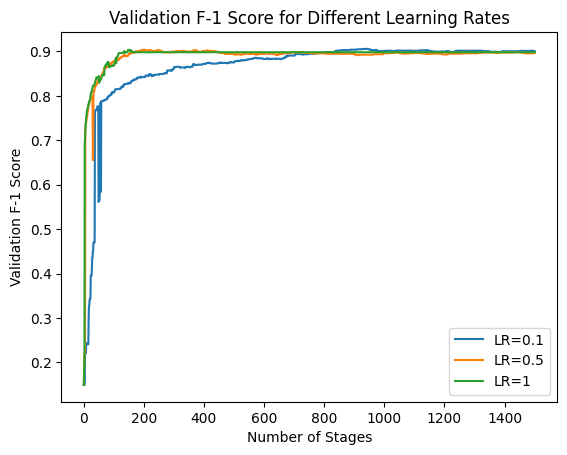

Best Learning Rate (best_lr): 0.1
Best Number of Stages (best_nstg): 927


In [12]:
# Plot the F-1 scores for different learning rates
plt.figure()
for i, lr in enumerate(learning_rates):
    plt.plot(range(1,n_estimators+1), f1_scores[i], label=f'LR={lr}')
plt.xlabel('Number of Stages')
plt.ylabel('Validation F-1 Score')
plt.legend()
plt.title('Validation F-1 Score for Different Learning Rates')
plt.show()

print("Best Learning Rate (best_lr):", best_lr)
print("Best Number of Stages (best_nstg):", best_nstg)

In [13]:
BestGBDTModel = GradientBoostingClassifier(learning_rate=best_lr, n_estimators=best_nstg)
BestGBDTModel.fit(x_trainandvalid, y_trainandvalid)
GBDT_y_pred = BestGBDTModel.predict(x_test)

In [14]:
from sklearn.metrics import accuracy_score

f1 = f1_score(y_test, GBDT_y_pred)
acc = accuracy_score(y_test, GBDT_y_pred)
precision = precision_score(y_test, GBDT_y_pred)
recall = recall_score(y_test, GBDT_y_pred)

sorted_indices = np.argsort(feature_importances)[::-1]
top_20_importances = feature_importances[sorted_indices[:20]]
top_20_indices = sorted_indices[:20]
top_20_feature_names = [feature_list[i] for i in top_20_indices]


print("Test F1 Score:", f1)
print("Test Accuracy:", acc)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Top 20 Features index:", top_20_values.tolist())
print("Top 20 Features' Names:", feature_list[top_20_indices].tolist())

Test F1 Score: 0.8593749999999999
Test Accuracy: 0.8646616541353384
Test Precision: 0.819366852886406
Test Recall: 0.9034907597535934
Top 20 Features index: [583, 1251, 1588, 834, 242, 1284, 31, 844, 1170, 463, 1480, 92, 527, 522, 1365, 704, 25, 803, 1133, 377]
Top 20 Features' Names: ['妤', '翔', '萱', '柏', '婷', '承', '怡', '佳', '芸', '_Other_Feature_', '蓁', '涵', '晴', '瑄', '宜', '柔', '芷', '雅', '哲', '瑜']


### Q1.5 組合(Stacking)成一個新的分類器

### Solve

Get probability after predicting male (sex = 1) for each models.

Then concatenate into a new data set, and start training.

In [21]:
Log_y_pred_stack = BestLogisticModel.predict_proba(x_stack)[:,1]
RF_y_pred_stack = BestRandomForestModel.predict_proba(x_stack)[:,1]
GBDT_y_pred_stack = BestGBDTModel.predict_proba(x_stack)[:,1]
processed_x_stack = np.concatenate((Log_y_pred_stack.reshape(-1,1), RF_y_pred_stack.reshape(-1,1), GBDT_y_pred_stack.reshape(-1,1)), axis=1)

LosgisticStackModel = LogisticRegression(max_iter=10000, penalty=None)
LosgisticStackModel.fit(processed_x_stack, y_stack)


LogisticRegression(max_iter=10000, penalty=None)

In [24]:
Log_y_pred_test = BestLogisticModel.predict_proba(x_test)[:,1]
RF_y_pred_test = BestRandomForestModel.predict_proba(x_test)[:,1]
GBDT_y_pred_test = BestGBDTModel.predict_proba(x_test)[:,1]
processed_x_test = np.concatenate((Log_y_pred_test.reshape(-1,1), RF_y_pred_test.reshape(-1,1), GBDT_y_pred_test.reshape(-1,1)), axis=1)

# print(processed_x_stack)
y_pred = LosgisticStackModel.predict(processed_x_test)
f1 = f1_score(y_test, y_pred)
acc = LosgisticStackModel.score(processed_x_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Test F1 Score:", f1)
print("Test Accuracy:", acc)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Coefficientes:", LosgisticStackModel.coef_)

Test F1 Score: 0.8771228771228771
Test Accuracy: 0.8843984962406015
Test Precision: 0.8540856031128404
Test Recall: 0.9014373716632443
Coefficientes: [[3.06306823 0.35647475 4.59791094]]


We can see that the result of this model is pretty good.

The weight for logistic regression is 3.06, Random Forest is 0.36, GBDT is 4.6

We can see that if GBDT has highest value, meaning among the three models, it's the one who mostly predicts the best.

Then for logistic regression, it has the second highest value, it's also a pretty good model as well.

However, for Random Forest has the lowest of three, meaning the value of it doesn't affect much for the whole model.

# Question 2

### Q2.1
